In [1]:
import scipy
import neurodsp
import glob
import matplotlib.pyplot as plt

In [6]:
minerva_directory = '/sc/arion/scratch/qasims01/misc'

local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
mat_files = glob.glob(f'{local_directory}/*.mat')

In [7]:
mat_files

['/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0001.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0002.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0003.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0004.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0005.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0006.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0007.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0008.mat']

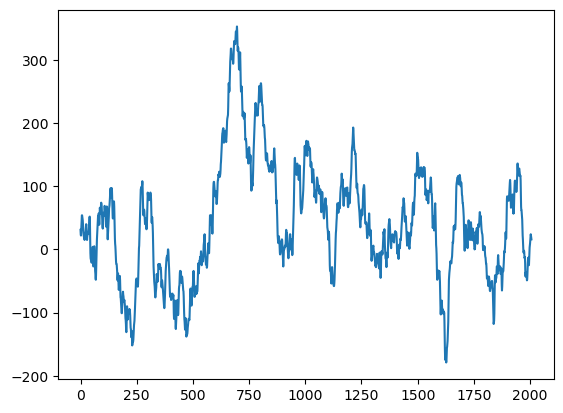

In [50]:
mat_file = scipy.io.loadmat(mat_files[0])

CLFP_01 = mat_file['CLFP_01']
plt.plot(CLFP_01[0,:])

In [32]:
# Load in the relevant neural data 
CMacro_LFP_01 = mat_file['CMacro_LFP_01']
CLFP_01 = mat_file['CLFP_01']

In [33]:
mat_file['CMacro_LFP_01_KHz']

array([[1.375]])

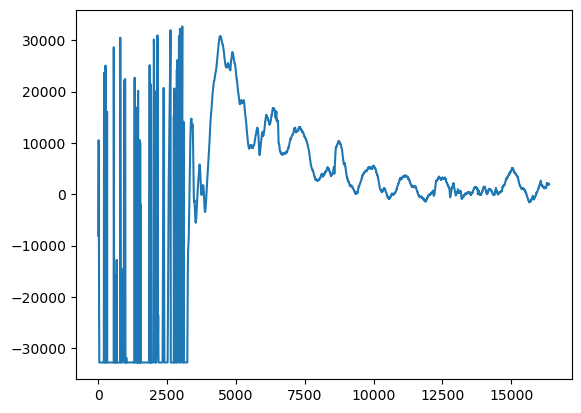

In [34]:
plt.plot(CLFP_01[0,:])

# Pre-processing IIR filtering

In [11]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
# Import functions for IIR filtering
from neurodsp.filt import filter_signal
from neurodsp.filt.iir import design_iir_filter, apply_iir_filter
from neurodsp.filt.utils import compute_frequency_response, compute_transition_band

# Import plotting functions
from neurodsp.plts import plot_frequency_response, plot_time_series

# Notch filter out the 60 Hz line noise 

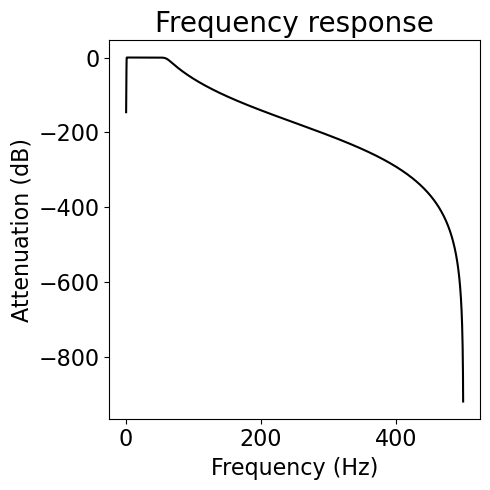

In [18]:
# setting (double check here later)
n_seconds = 1
fs = 1000

# Define filter settings
pass_type = 'bandpass'
f_range = (1, 60) #changed from 50 to 60 here
butterworth_order = 12

# Design the filter, getting the second-order series (sos) values for the filter
sos = design_iir_filter(fs, pass_type, f_range, butterworth_order)

# Compute the frequency response for the IIR filter
f_db, db = compute_frequency_response(sos, None, fs)

# Plot the frequency response
plot_frequency_response(f_db, db)

In [ ]:
times = create_times(n_seconds, fs)

components = {'sim_powerlaw' : {'exponent' : 0},
              'sim_oscillation' : {'freq' : 10}}
variances = [0.1, 1]
sig = sim_combined(n_seconds, fs, components, variances)

In [ ]:
#not sure how actual data map onto the simulation settings

times = CLFP_01[0,:]
sig = sim_combined(n_seconds, fs, components, variances)

# Apply the filter to our signal
sig_filt = apply_iir_filter(sig, sos)

# Plot the filtered and original time series
plot_time_series(times, [sig, sig_filt], ['Raw', 'Filtered'])

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


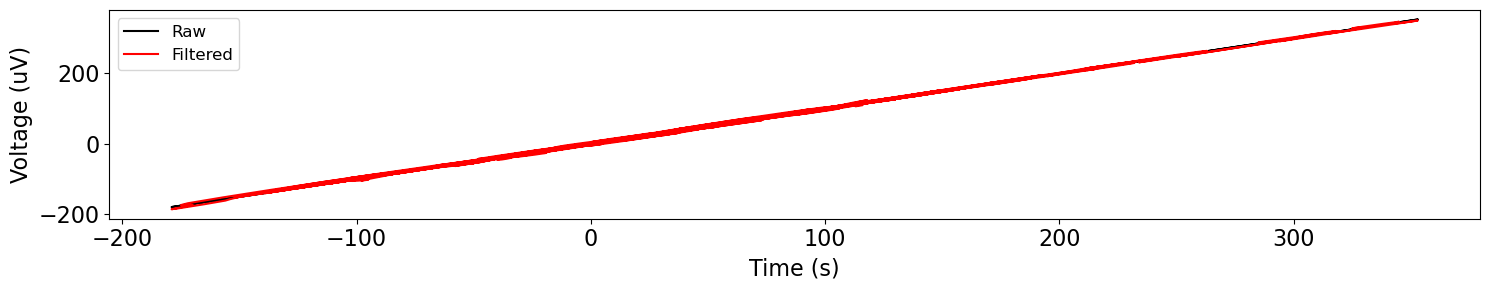

In [49]:
#filtering test

from neurodsp.utils import create_times

# Filter settings
f_range = (58, 62)
order = 3

fs = 1000 #double check
sig = CLFP_01[0,:]
n_seconds = 1
times = create_times(n_seconds, fs) #don't know what's doing here

# Bandstop filter the data to remove line noise
sig_filt = filter_signal(sig, fs, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal
plot_time_series(times, [sig, sig_filt], ['Raw', 'Filtered'])

# Analysis

In [26]:
# Analysis: https://neurodsp-tools.github.io/neurodsp/

# Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py

# time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py



# FOOF pipeline 

pre-post 1 minute power curve


In [ ]:
# EVENTUALLY: Load in the behavioral data and synchronize it to the neural 